# Random forest p53 classification

In [22]:
## Imports

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

## 1. Loading the data

remove unnecessary quotes from csv files (result from edgeR)
```
tr -d '"' < meta_data_with_norm_factors.csv > meta.csv
tr -d '"' < count_data_EdgeR_preprocessed.csv > count.csv
```

In [2]:
dataset = pd.read_csv("Data/count.csv", index_col = 0)
metadata = pd.read_csv("Data/meta.csv", index_col = 0)

In [3]:
dataset.set_index('cases.0.samples.0.submitter_id', inplace=True, drop=True)
metadata.set_index('cases.0.samples.0.submitter_id', inplace=True, drop=True)

In [72]:
len(dataset)

9576

### Exploration

In [70]:
value_counts = metadata['cases.0.project.project_id'].value_counts()

# Get the total number of different values
total_unique_values = metadata['cases.0.project.project_id'].nunique()

print("Cancers and their counts:")
print(value_counts)

print("\nTotal number of different cancer types:", total_unique_values)

Cancers and their counts:
cases.0.project.project_id
TCGA-BRCA    1017
TCGA-UCEC     529
TCGA-LGG      523
TCGA-LUAD     513
TCGA-HNSC     497
TCGA-THCA     496
TCGA-PRAD     494
TCGA-LUSC     482
TCGA-SKCM     467
TCGA-BLCA     404
TCGA-COAD     404
TCGA-STAD     372
TCGA-KIRC     367
TCGA-LIHC     360
TCGA-CESC     288
TCGA-KIRP     281
TCGA-OV       257
TCGA-SARC     237
TCGA-PCPG     183
TCGA-PAAD     169
TCGA-ESCA     162
TCGA-GBM      159
TCGA-TGCT     150
TCGA-READ     146
TCGA-THYM     119
TCGA-MESO      82
TCGA-UVM       80
TCGA-ACC       79
TCGA-LAML      65
TCGA-KICH      65
TCGA-UCS       57
TCGA-DLBC      37
TCGA-CHOL      35
Name: count, dtype: int64

Total number of different cancer types: 33


### Concatenate with labels

In [4]:
## Labels 
metadata = metadata[~metadata.index.duplicated(keep='first')] ## remove some duplicated rows

## Make sure that rows (samples) in the counts matrix (dataset) are in the same order as the metadata
dataset = dataset.loc[metadata.index]
## Add the class (1/0) as final column to the dataset
dataset['mutated'] = metadata.iloc[:,-2]

In [5]:
# Split data into training and test sets
X = dataset.iloc[:, :-1]  # Features
y = dataset['mutated']  # Target variable

In [41]:
# ration of mutated vs non mutated

sum(y)/len(y)

0.3717627401837928

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. Spatial data simulation & data splitting

In [12]:
# Spatial data simulation
def CreateSTSim(X, y, num_circles=6, grid_size=64, circle_radius=[4, 9], seed=None):
    # Set a seed for reproducibility if provided
    if seed is not None:
        np.random.seed(seed)

    # Create node features and labels
    node_features = np.zeros((grid_size, grid_size, X.shape[1]))  # Node features
    node_labels = np.zeros((grid_size, grid_size), dtype=float)  # Node labels
    node_names = list()
    radii = np.random.randint(circle_radius[0], circle_radius[1], size=num_circles)  # Random radii to define circle (clone) sizes within circle_radius limits
    circle_midpoints = np.random.randint(circle_radius[0], grid_size - circle_radius[0], size=(num_circles, 2))  # Define random circle midpoints within the grid size

    # Split data into class 1 and class 0 to make further processing faster
    data1 = X[y == 1]
    data0 = X[y == 0]

    # Assign class labels based on circle/clone location
    for i in range(grid_size):
        for j in range(grid_size):
            # Calculate distance between spot and each clone midpoint
            x = np.array([i, j])
            distances = np.linalg.norm(x - circle_midpoints, axis=1)
            if np.any(distances <= radii):
                # If spot is within any clone (closer to the midpoint of the clone than the circle radius), assign class 1
                node_labels[i, j] = 1
                random_index = np.random.choice(len(data1.index))
                node_features[i, j] = data1.iloc[random_index].values
                node_names.append(data1.index[random_index])
            else:
                # Spot is outside a clone: class 0
                random_index = np.random.choice(len(data0.index))
                node_features[i, j] = data0.iloc[random_index].values
                node_names.append(data0.index[random_index])

    return node_features, node_labels, np.array(node_names).reshape(grid_size, grid_size)

In [53]:
# Spatial data simulation for training set
grid_size = 64
features_train, labels_train, samples_train = CreateSTSim(X_train, y_train, num_circles=8, grid_size=grid_size, circle_radius=[9, 13], seed=1)

In [54]:
# ratio mutated vs non mutated (try to match this to original ratio)
sum(labels_train.flatten())/len(labels_train.flatten())

0.38134765625

In [55]:
# Spatial data simulation for test set
features_test, labels_test, samples_test = CreateSTSim(X_test, y_test, num_circles=6, grid_size=grid_size, circle_radius=[4, 9], seed=1)

## 3. Random forest model

In [56]:
# Further processing for training and testing
# Reshape the features to prepare for modeling - for training and testing sets
reshaped_features_train = features_train.reshape(-1, features_train.shape[2])  # Reshape training features
reshaped_features_test = features_test.reshape(-1, features_test.shape[2])  # Reshape test features

# Flatten the labels - for training and testing sets
flattened_labels_train = labels_train.flatten()  # Flatten training labels
flattened_labels_test = labels_test.flatten()  # Flatten test labels

In [57]:
# Model training using simulated training data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(reshaped_features_train, flattened_labels_train)

RandomForestClassifier(random_state=42)

In [58]:
#Predict on the simulated test set
predictions_test = rf_classifier.predict(reshaped_features_test)

## 4. Evaluation

In [59]:
# Evaluate the model on the simulated test data
accuracy_test = accuracy_score(flattened_labels_test, predictions_test)
print(f"Accuracy on Test Data: {accuracy_test}")

# Additional evaluation metrics for test data
print("Classification Report on Test Data:")
print(classification_report(flattened_labels_test, predictions_test))

print("Confusion Matrix on Test Data:")
print(confusion_matrix(flattened_labels_test, predictions_test))


Accuracy on Test Data: 0.88330078125
Classification Report on Test Data:
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      3499
         1.0       0.58      0.71      0.64       597

    accuracy                           0.88      4096
   macro avg       0.77      0.81      0.78      4096
weighted avg       0.90      0.88      0.89      4096

Confusion Matrix on Test Data:
[[3194  305]
 [ 173  424]]


## 5. Visualisations

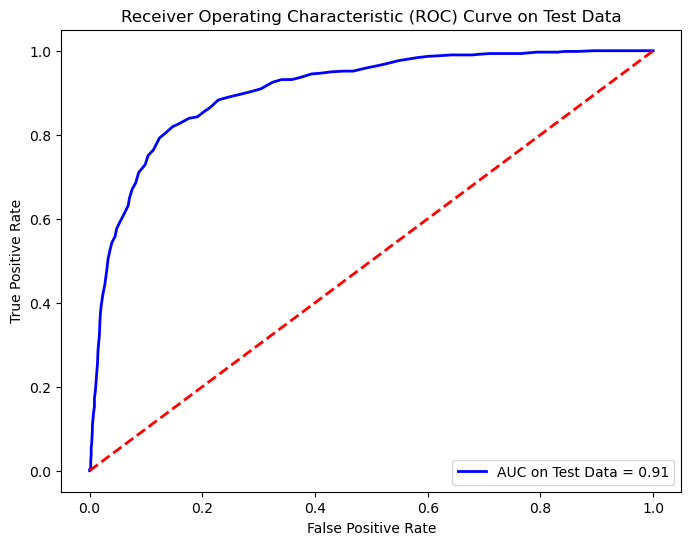

In [60]:
# Get predicted probabilities for test data
probs_test = rf_classifier.predict_proba(reshaped_features_test)
preds_test = probs_test[:, 1]

# Calculate ROC curve and AUC for test data
fpr_test, tpr_test, threshold_test = roc_curve(flattened_labels_test, preds_test)
roc_auc_test = auc(fpr_test, tpr_test)
# Plot ROC curve for test data
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'AUC on Test Data = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on Test Data')
plt.legend(loc='lower right')
plt.show()

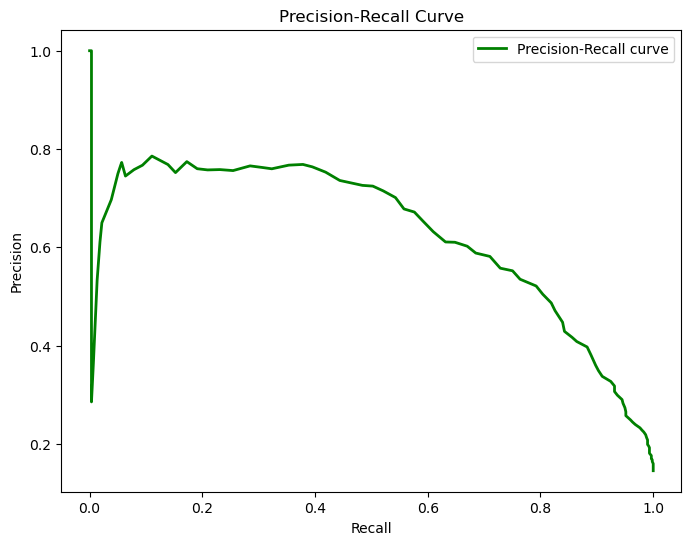

In [61]:
precision, recall, _ = precision_recall_curve(flattened_labels_test, preds_test)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


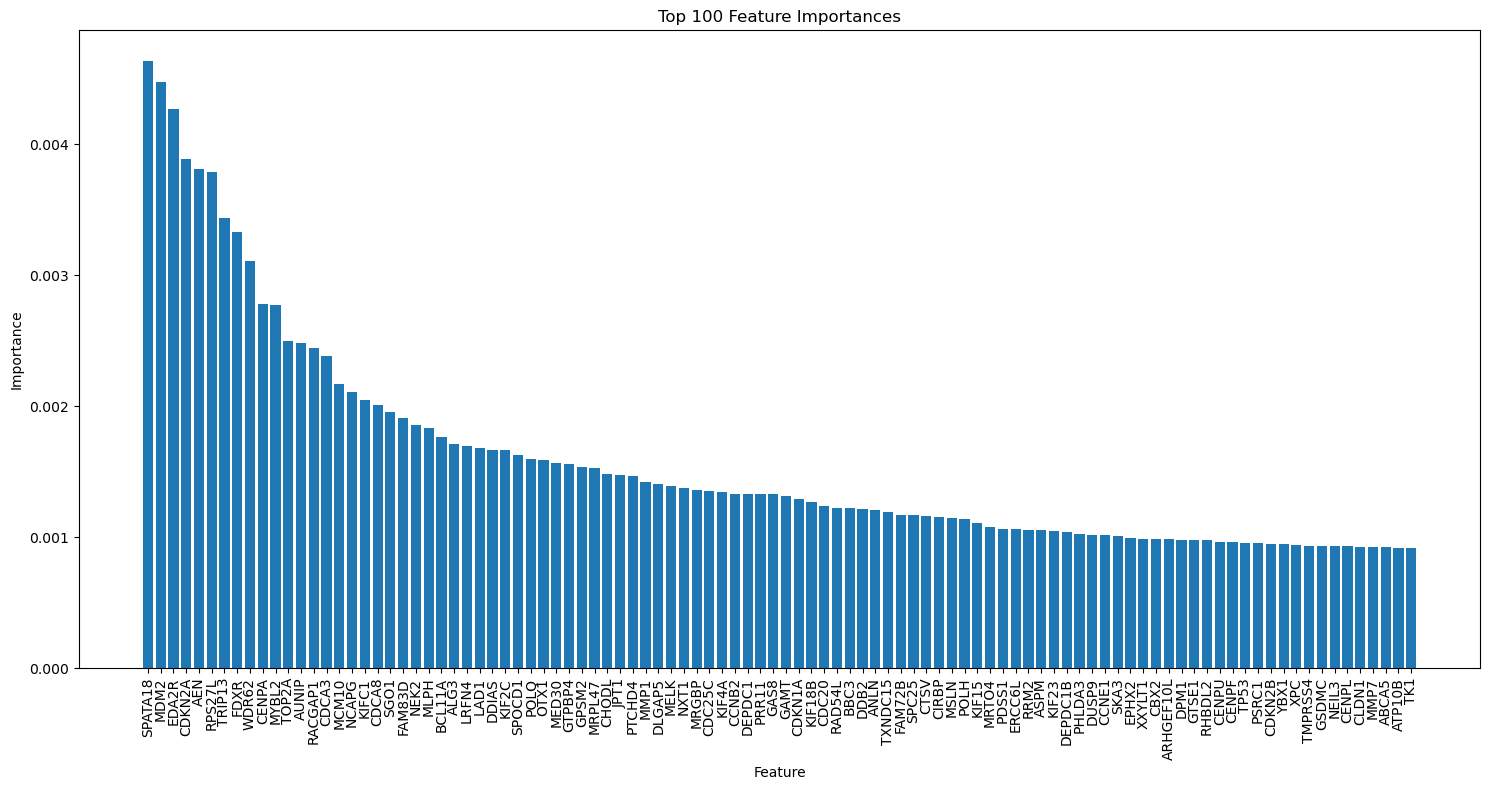

In [73]:
feature_importances = rf_classifier.feature_importances_
feature_names = dataset.columns[:-1]  # Excluding the target variable
sorted_indices = np.argsort(feature_importances)[::-1]

top_feature_importances = feature_importances[sorted_indices][:100]
top_feature_names = feature_names[sorted_indices][:100]

plt.figure(figsize=(15, 8))  # Adjust the figure size as needed
plt.bar(range(100), top_feature_importances, align='center')
plt.xticks(range(100), top_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 100 Feature Importances')
plt.tight_layout()  # To ensure labels fit within the figure
plt.show()

Mainly p53 regulators

Confusion Matrix on Test Data:
[[3194  305]
 [ 173  424]]


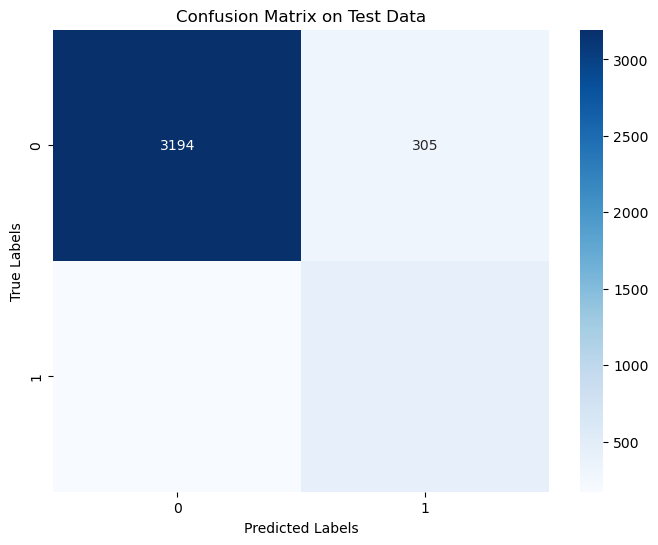

In [64]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(flattened_labels_test, predictions_test)
print("Confusion Matrix on Test Data:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Data')
plt.show()

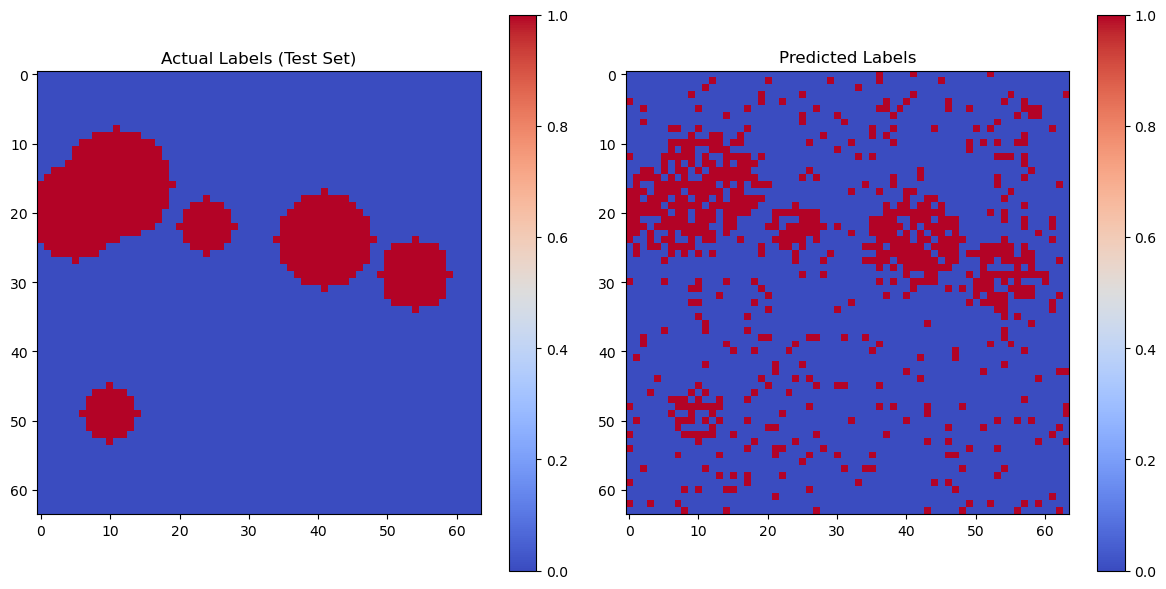

In [63]:
# Reshape predicted labels back into a grid
predicted_grid = predictions_test.reshape(grid_size, grid_size)

# Create subplots to compare actual labels and predicted labels
plt.figure(figsize=(12, 6))

# Plot for actual labels
plt.subplot(1, 2, 1)
plt.imshow(labels_test, cmap='coolwarm', interpolation='nearest')
plt.title('Actual Labels (Test Set)')
plt.colorbar()

# Plot for predicted labels
plt.subplot(1, 2, 2)
plt.imshow(predicted_grid, cmap='coolwarm', interpolation='nearest')
plt.title('Predicted Labels')
plt.colorbar()

plt.tight_layout()
plt.show()
